# Creating Database:

Prepare notebook to run sql:

In [8]:
# pip install sqlalchemy #if necessary
# pip install ipython-sql
%load_ext sql

In [81]:
import csv, sqlite3
#connect to db, create connection and cursor variables:
con = sqlite3.connect("socioeconomic.db")
cur = con.cursor()

In [83]:
%sql sqlite:///socioeconomic.db

In [38]:
import pandas as pd
#read in data and write to sql
df = pd.read_csv('Chicago_Census_Data.csv')
#remove spaces from column names and replace with '_'
df.columns = df.columns.str.replace(' ', '_')
#drop the '+'character as this will cause issues with sql commands
df.columns = df.columns.str.replace('+', '')
df.to_sql("chicago_socioeconomic_data", con, if_exists='replace', index=False,method="multi")
#retrieve first 5 rows of data
%sql SELECT * FROM chicago_socioeconomic_data limit 5;

 * sqlite:///socioeconomic.db
Done.


Community_Area_Number,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME_,HARDSHIP_INDEX
1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


# Data Exploration:

How many rows are in the dataset?

In [80]:
#with pandas:
print('Number of rows using Pandas: ' + str(len(df)))
print()

#With sql:
print('Number of rows using Sql:')
%sql SELECT count(*) as 'Number of rows' FROM chicago_socioeconomic_data

Number of rows using Pandas: 78

Number of rows using Sql:
 * sqlite:///socioeconomic.db
Done.


Number of rows
78


How many communities have a hardship index greater than 50?

In [66]:
#using pandas:
count = df[df['HARDSHIP_INDEX'] > 50].shape[0]

print(f"Number of communities where {'HARDSHIP INDEX'} is greater than {50} using Pandas: {count}")
print()

#using SQL:
print('Number of communities using Sql:')
%sql SELECT count(*) as 'Number of communities' FROM chicago_socioeconomic_data WHERE HARDSHIP_INDEX > 50

Number of communities where HARDSHIP INDEX is greater than 50 using Pandas: 38

Number of communities using Sql:
 * sqlite:///socioeconomic.db
Done.


Number of communities
38


What is the community with the highest hardship index?

In [27]:
#using pandas:
max_index = df['HARDSHIP_INDEX'].idxmax()
community = df.loc[max_index, 'COMMUNITY_AREA_NAME']
hardship = df.loc[max_index, 'HARDSHIP_INDEX']

print('Using python:')
print(f"The community with the highest Hardship Index is: {community} with a hardship index of: {hardship}")
print()

#using SQL:
max = %sql SELECT MAX(hardship_index) FROM chicago_socioeconomic_data;
max_value = max[0][0]

community_sql = %sql SELECT community_area_name FROM chicago_socioeconomic_data \
where hardship_index=(SELECT MAX(hardship_index) FROM chicago_socioeconomic_data);

community_value = community_sql[0][0]

print()
print('Using sql:')
print(f"The community with the highest Hardship Index is: {community_value} with a hardship index of: {max_value}")

Using python:
The community with the highest Hardship Index is: Riverdale with a hardship index of: 98.0

 * sqlite:///socioeconomic.db
Done.
 * sqlite:///socioeconomic.db
Done.

Using sql:
The community with the highest Hardship Index is: Riverdale with a hardship index of: 98.0


Which communities have per capita income greater than $60k?

In [67]:
#using python:
h_income_comms = df[df['PER_CAPITA_INCOME_'] > 60000]['COMMUNITY_AREA_NAME'].tolist()
print('Using Python:')
print(f"The communities with per capita income above $60k/year are: {h_income_comms}")
print()

#Using sql:
print('Using Sql:')
%sql SELECT COMMUNITY_AREA_NAME as 'High Income Areas', PER_CAPITA_INCOME_ as 'Per Capita Income'\
FROM chicago_socioeconomic_data WHERE PER_CAPITA_INCOME_ > 60000

Using Python:
The communities with per capita income above $60k/year are: ['Lake View', 'Lincoln Park', 'Near North Side', 'Loop']

Using Sql:
 * sqlite:///socioeconomic.db
Done.


High Income Areas,Per Capita Income
Lake View,60058
Lincoln Park,71551
Near North Side,88669
Loop,65526


What is the relationship between per capita income and hardship index?

 * sqlite:///socioeconomic.db
Done.


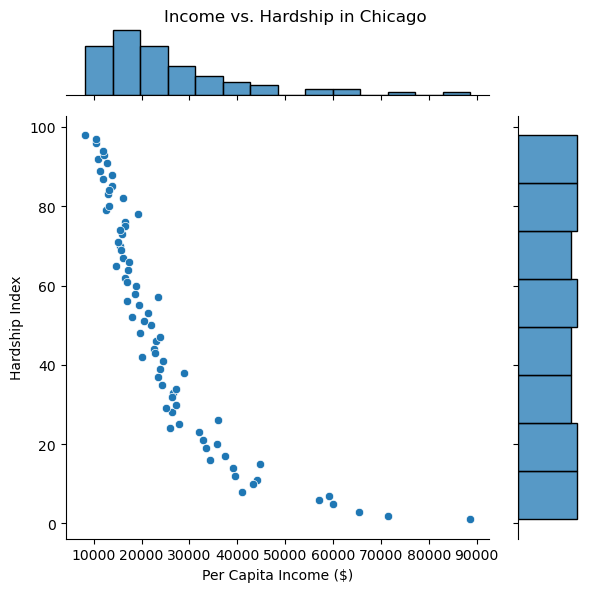

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#pull data using sql for plot
plot_data = %sql SELECT PER_CAPITA_INCOME_, HARDSHIP_INDEX FROM chicago_socioeconomic_data;
plot_data = plot_data.DataFrame()

# configure plot
plot = sns.jointplot(x='PER_CAPITA_INCOME_',y='HARDSHIP_INDEX', data=plot_data)

# format plot
plt.xlabel('Per Capita Income ($)')
plt.ylabel('Hardship Index')
plot.fig.suptitle('Income vs. Hardship in Chicago')
plot.fig.tight_layout()
plot.fig.subplots_adjust(top=0.95)
plt.show()

Conclusion: As Per Capita Income increases, the hardship index decreases. There is a negative correlation between the two.

What is the relationship between per capita income and employment of 16 year olds?

 * sqlite:///socioeconomic.db
Done.


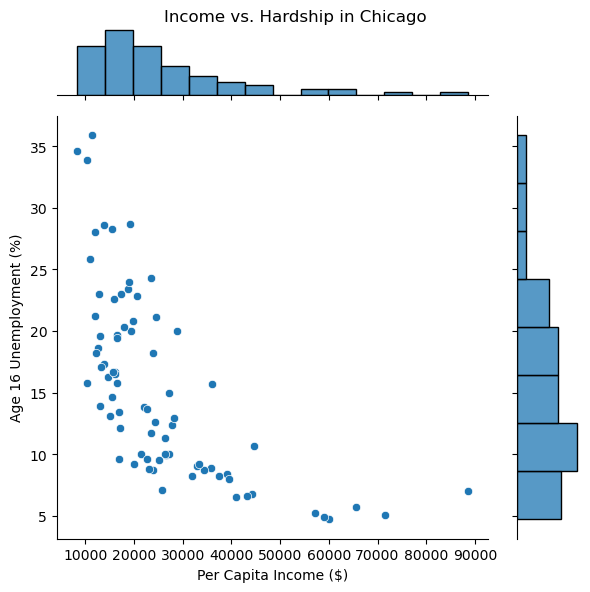

In [40]:
#pull data using sql for plot
plot_data = %sql SELECT PER_CAPITA_INCOME_, PERCENT_AGED_16_UNEMPLOYED FROM chicago_socioeconomic_data;
plot_data = plot_data.DataFrame()

# configure plot
plot = sns.jointplot(x='PER_CAPITA_INCOME_',y='PERCENT_AGED_16_UNEMPLOYED', data=plot_data)

# format plot
plt.xlabel('Per Capita Income ($)')
plt.ylabel('Age 16 Unemployment (%)')
plot.fig.suptitle('Income vs. Hardship in Chicago')
plot.fig.tight_layout()
plot.fig.subplots_adjust(top=0.95)
plt.show()

Conclusion: Unemployment rates decrease among 16 year olds in high income communities. There could be 2 factors to explain this, people in lower income areas could have a harder time finding/gaining employement. Or, because unemployment rates factor in people who are actively looking for jobs, a possible hypothesis is that higher income area 16 year olds are less likely to be looking for jobs. Since there is less pressure to support their family financially, they do not search for jobs at as high of a rate. 

More data like percentage of 16 year olds in the labor force, and rates of job applications vs job offers would be needed to determine if either or both of these factors could explain the data.

# Comparing Data from 2 Tables in SQL

I will now bring in data from school data to compare it against the census data I have been looking at

In [93]:
#Bring the data in, this time I will read it directly from the City of Chicago website:
school = pd.read_csv ("https://data.cityofchicago.org/resource/9xs2-f89t.csv")

#Read the data to a new sql table in the db
school.to_sql("CHICAGO_PUBLIC_SCHOOLS_DATA", con, if_exists='replace', index=False, method="multi")
#print dataframe
school.head()

,school_id,name_of_school,elementary_or_high_school,street_address,city,state,zip_code,phone_number,link_,network_manager,...,rcdts_code,x_coordinate,y_coordinate,latitude,longitude,community_area_number,community_area_name,ward,police_district,location
0,610038,Abraham Lincoln Elementary School,ES,615 W Kemper Pl,Chicago,IL,60614,(773) 534-5720,http://schoolreports.cps.edu/SchoolProgressRep...,Fullerton Elementary Network,...,150000000000000,1171699.458,1915829.428,41.924497,-87.644522,7,LINCOLN PARK,43,18,"(41.92449696, -87.64452163)"
1,610281,Adam Clayton Powell Paideia Community Academy ...,ES,7511 S South Shore Dr,Chicago,IL,60649,(773) 535-6650,http://schoolreports.cps.edu/SchoolProgressRep...,Skyway Elementary Network,...,150000000000000,1196129.985,1856209.466,41.760324,-87.556736,43,SOUTH SHORE,7,4,"(41.76032435, -87.55673627)"
2,610185,Adlai E Stevenson Elementary School,ES,8010 S Kostner Ave,Chicago,IL,60652,(773) 535-2280,http://schoolreports.cps.edu/SchoolProgressRep...,Midway Elementary Network,...,150000000000000,1148427.165,1851012.215,41.747111,-87.731702,70,ASHBURN,13,8,"(41.74711093, -87.73170248)"
3,609993,Agustin Lara Elementary Academy,ES,4619 S Wolcott Ave,Chicago,IL,60609,(773) 535-4389,http://schoolreports.cps.edu/SchoolProgressRep...,Pershing Elementary Network,...,150000000000000,1164504.290,1873959.199,41.809757,-87.672145,61,NEW CITY,20,9,"(41.8097569, -87.6721446)"
4,610513,Air Force Academy High School,HS,3630 S Wells St,Chicago,IL,60609,(773) 535-1590,http://schoolreports.cps.edu/SchoolProgressRep...,Southwest Side High School Network,...,150000000000000,1175177.622,1880745.126,41.828146,-87.632794,34,ARMOUR SQUARE,11,9,"(41.82814609, -87.63279369)"


What is the per capita income and hardship index for the 10 High Schools with the lowest safety score?

In [254]:
%%sql 
SELECT CPS.name_of_school as "School name", CD.PER_CAPITA_INCOME_ as " Per Capita Income ($)",
    CD.HARDSHIP_INDEX as "Hardship Index", CPS.safety_score
    FROM CHICAGO_PUBLIC_SCHOOLS_DATA CPS, chicago_socioeconomic_data CD
    WHERE CPS.community_area_number  = CD.community_area_number AND CPS.safety_score IN
    (select safety_score FROM CHICAGO_PUBLIC_SCHOOLS_DATA WHERE elementary_or_high_school = 'HS' 
    ORDER BY safety_score nulls last limit 10)
    ORDER BY CPS.safety_score nulls last limit 10

 * sqlite:///socioeconomic.db
Done.


School name,Per Capita Income ($),Hardship Index,safety_score
Emil G Hirsch Metropolitan High School,17285,66.0,13.0
John Fiske Elementary School,18672,58.0,13.0
William W Carter Elementary School,13785,88.0,13.0
Countee Cullen Elementary School,17949,52.0,14.0
Gage Park High School,12171,93.0,14.0
Isabelle C O'Keeffe Elementary School,19398,55.0,17.0
New Millennium High School of Health at Bowen,16579,75.0,17.0
Songhai Elementary Learning Institute,16563,62.0,17.0
Charles S Brownell Elementary School,17285,66.0,20.0
Florence B Price Elementary School,35911,26.0,20.0


What are the graduation rates of High Schools in the lowest five income per capita communities?

In [213]:
%%sql 
SELECT CPS.name_of_school as "School name", CPS.community_area_name as "Community", 
    CPS.graduation_rate_ as 'Graduation rate (%)', CD.PER_CAPITA_INCOME_ as " Per Capita Income ($)"
    FROM CHICAGO_PUBLIC_SCHOOLS_DATA CPS, chicago_socioeconomic_data CD
    WHERE CPS.community_area_number  = CD.community_area_number AND CPS.community_area_number IN
    (select community_area_number FROM chicago_socioeconomic_data ORDER BY PER_CAPITA_INCOME_ nulls last limit 5)
    AND CPS.graduation_rate_ <> 'NDA' AND CPS.elementary_or_high_school = 'HS'
    ORDER BY CD.PER_CAPITA_INCOME_

 * sqlite:///socioeconomic.db
Done.


School name,Community,Graduation rate (%),Per Capita Income ($)
George Washington Carver Military Academy High School,RIVERDALE,78.7,8201
David G Farragut Career Academy High School,SOUTH LAWNDALE,43.2,10402
Greater Lawndale High School For Social Justice,SOUTH LAWNDALE,67,10402
Infinity Math Science and Technology High School,SOUTH LAWNDALE,84.4,10402
Multicultural Academy of Scholarship,SOUTH LAWNDALE,58,10402
Spry Community Links High School,SOUTH LAWNDALE,73.7,10402
World Language Academy High School,SOUTH LAWNDALE,69.4,10402
Robert Lindblom Math & Science Academy High School,WEST ENGLEWOOD,68.9,11317
Southside Occupational Academy High School,WEST ENGLEWOOD,71.7,11317
William Rainey Harper High School,WEST ENGLEWOOD,37,11317


What about the highest five? How does this compare to the city average?

In [221]:
%%sql 
SELECT CPS.name_of_school as "School name", CPS.community_area_name as "Community", 
    CPS.graduation_rate_ as 'Graduation rate (%)', CD.PER_CAPITA_INCOME_ as " Per Capita Income ($)"
    FROM CHICAGO_PUBLIC_SCHOOLS_DATA CPS, chicago_socioeconomic_data CD
    WHERE CPS.community_area_number  = CD.community_area_number AND CPS.community_area_number IN
    (select community_area_number FROM chicago_socioeconomic_data ORDER BY PER_CAPITA_INCOME_ DESC nulls last limit 5)
    AND CPS.graduation_rate_ <> 'NDA' AND CPS.elementary_or_high_school = 'HS'
    ORDER BY CD.PER_CAPITA_INCOME_ DESC

 * sqlite:///socioeconomic.db
Done.


School name,Community,Graduation rate (%),Per Capita Income ($)
Walter Payton College Preparatory High School,NEAR NORTH SIDE,96.9,88669
Lincoln Park High School,LINCOLN PARK,77.9,71551
William Jones College Preparatory High School,LOOP,90.1,65526
Lake View High School,LAKE VIEW,81.4,60058
Ray Graham Training Center High School,NEAR SOUTH SIDE,10.3,59077


In [197]:
%%sql 
SELECT AVG(graduation_rate_) as 'City Wide Average Graduation Rate'

 * sqlite:///socioeconomic.db
Done.


City Wide Average Graduation Rate
61.67088607594937


# Plotting

In [258]:
#Close connection to db

con.close()